# 2 Multi-armed Bandits

In [89]:
import numpy as np

# class Bandit:
#     def __init__(self, k=10, q1=0):
#         self.k = k
#         self.q_true = np.random.normal(0, 1, k)
#         self.q_estimates = np.full(k, q1, dtype=float)
#         self.action_counts = np.zeros(k)
#         self.time = 0

#     def step(self, action):
#         reward = np.random.normal(self.q_true[action], 1)
#         self.q_true += np.random.normal(0, 0.01, self.k)  # Random walk
#         return reward

#     def select_action(self, epsilon):
#         if np.random.rand() < epsilon:
#             return np.random.choice(self.k)  # Exploration
#         else:
#             return np.argmax(self.q_estimates)  # Exploitation

#     def update_estimates(self, action, reward, alpha=None):
#         self.action_counts[action] += 1
#         if alpha is None:
#             # Sample-average method
#             self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]
#         else:
#             # Constant step-size method
#             self.q_estimates[action] += alpha * (reward - self.q_estimates[action])

class Bandit:
    def __init__(self, k=10, q1=0, mu=0, stationary=True):
        self.k = k
        self.q_true = np.random.normal(mu, 1, k)
        self.q_estimates = np.full(k, q1, dtype=float)
        self.action_counts = np.zeros(k)
        self.time = 0
        self.stationary = stationary

    def step(self, action):
        reward = np.random.normal(self.q_true[action], 1)
        if not self.stationary:
            self.q_true += np.random.normal(0, 0.01, self.k)  # Random walk
        return reward

    def select_action(self, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.k)  # Exploration
        else:
            return np.argmax(self.q_estimates)  # Exploitation

    def update_estimates(self, action, reward, alpha=None):
        self.action_counts[action] += 1
        if alpha is None:
            # Sample-average method
            self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]
        else:
            # Constant step-size method
            self.q_estimates[action] += alpha * (reward - self.q_estimates[action])


class GradientBandit:
    def __init__(self, k=10, alpha=0.1, mu=0, use_baseline=True):
        self.k = k
        self.alpha = alpha
        self.use_baseline = use_baseline
        self.q_true = np.random.normal(mu, 1, k)
        self.preferences = np.zeros(k)
        self.action_counts = np.zeros(k)
        self.average_reward = 0
        self.time = 0

    def softmax(self):
        exp_preferences = np.exp(self.preferences)
        return exp_preferences / np.sum(exp_preferences)

    def select_action(self):
        probabilities = self.softmax()
        return np.random.choice(self.k, p=probabilities)

    def update_preferences(self, action, reward):
        self.action_counts[action] += 1
        self.time += 1
        probabilities = self.softmax()

        if self.use_baseline:
            self.average_reward += (reward - self.average_reward) / self.time

        baseline = self.average_reward if self.use_baseline else 0
        self.preferences += self.alpha * (reward - baseline) * (np.eye(self.k)[action] - probabilities)


## Figure 2.1

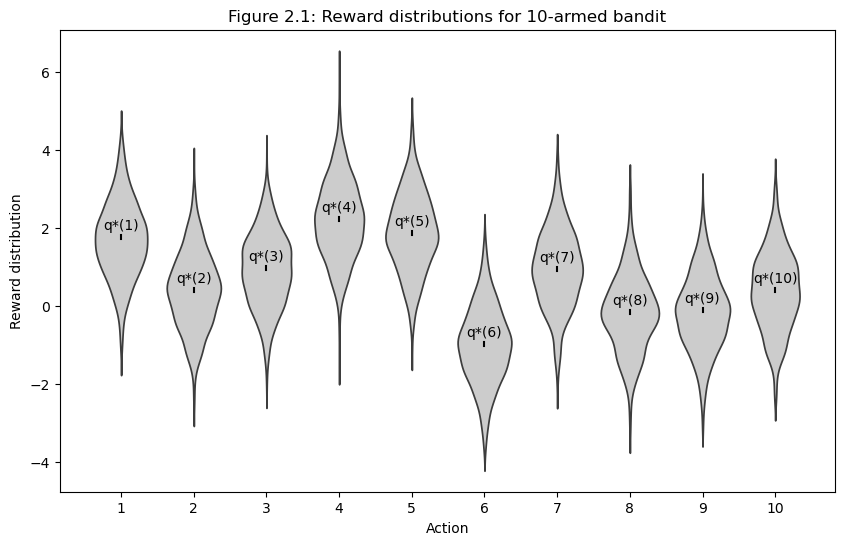

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(0)

# Number of arms
k = 10

# Initialize Bandit class
bandit = Bandit(k)

# Generate rewards for each action
rewards = [np.random.normal(bandit.q_true[i], 1, 1000) for i in range(k)]

# Plotting
plt.figure(figsize=(10, 6))

# Create violin plot for reward distributions
sns.violinplot(data=rewards, inner=None, color=".8")

# Add true action values (q_*(a)) to the plot
for i in range(k):
    plt.plot([i, i], [bandit.q_true[i] - 0.05, bandit.q_true[i] + 0.05], color='black')
    plt.text(i, bandit.q_true[i] + 0.2, f'q*({i+1})', ha='center')

# Add labels and title
plt.xlabel('Action')
plt.ylabel('Reward distribution')
plt.title('Figure 2.1: Reward distributions for 10-armed bandit')
plt.xticks(range(k), range(1, k+1))

plt.show()

## Figure 2.2

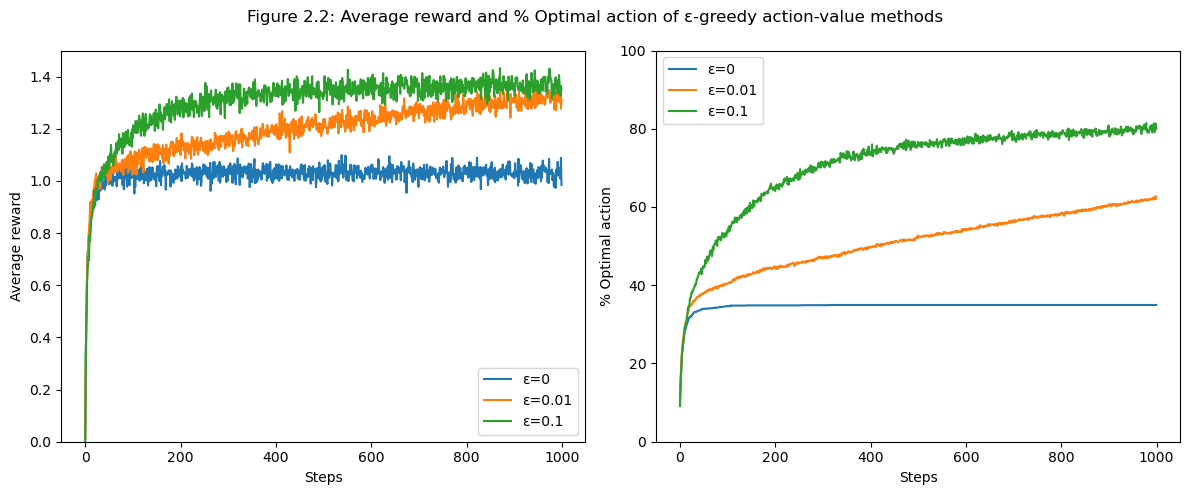

In [91]:
import numpy as np
import matplotlib.pyplot as plt
             
def run_experiment(epsilon, steps=1000, runs=2000):
    rewards = np.zeros(steps)
    optimal_action_counts = np.zeros(steps)
    
    for _ in range(runs):
        bandit = Bandit()
        optimal_action = np.argmax(bandit.q_true)
        
        for step in range(steps):
            action = bandit.select_action(epsilon)
            reward = bandit.step(action)
            bandit.update_estimates(action, reward)
            
            rewards[step] += reward
            if action == optimal_action:
                optimal_action_counts[step] += 1
                
    rewards /= runs
    optimal_action_counts /= runs
    
    return rewards, optimal_action_counts

# Parameters
steps = 1000
runs = 2000
epsilons = [0, 0.01, 0.1]

# Run experiments
results = {}
for epsilon in epsilons:
    rewards, optimal_action_counts = run_experiment(epsilon)
    results[epsilon] = (rewards, optimal_action_counts)

# Plotting
plt.figure(figsize=(12, 5))
plt.suptitle('Figure 2.2: Average reward and % Optimal action of ε-greedy action-value methods')

# Plot average rewards
plt.subplot(1, 2, 1)
for epsilon in epsilons:
    plt.plot(results[epsilon][0], label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.ylim(0, 1.5)
plt.tight_layout()
plt.legend()

# Plot % optimal action
plt.subplot(1, 2, 2)
for epsilon in epsilons:
    plt.plot(results[epsilon][1] * 100, label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## Figure 2.3

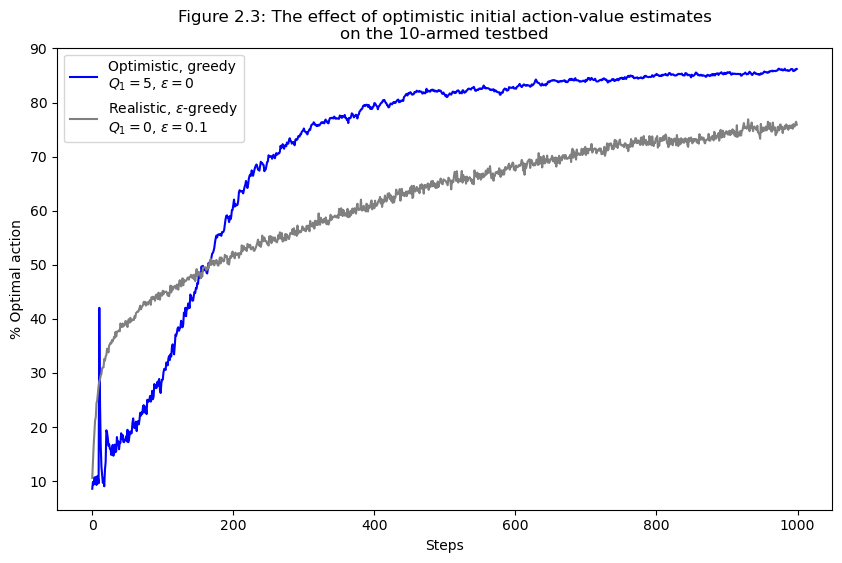

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment(epsilon, q1, steps=1000, runs=2000, alpha=0.1):
    optimal_action_counts = np.zeros(steps)
    
    for _ in range(runs):
        bandit = Bandit(q1=q1)
        optimal_action = np.argmax(bandit.q_true)
        
        for step in range(steps):
            action = bandit.select_action(epsilon)
            reward = bandit.step(action)
            bandit.update_estimates(action, reward, alpha)
            
            if action == optimal_action:
                optimal_action_counts[step] += 1
                
    optimal_action_counts /= runs
    
    return optimal_action_counts

# Parameters
steps = 1000
runs = 2000
alpha = 0.1

# Run experiments
optimal_action_counts_optimistic = run_experiment(0, 5, steps, runs, alpha)
optimal_action_counts_realistic = run_experiment(0.1, 0, steps, runs, alpha)


# Plotting
plt.figure(figsize=(10, 6))

# Plot % optimal action
plt.plot(optimal_action_counts_optimistic * 100, label='Optimistic, greedy\n$Q_1=5$, $\epsilon=0$', color='blue')
plt.plot(optimal_action_counts_realistic * 100, label='Realistic, $\epsilon$-greedy\n$Q_1=0$, $\epsilon=0.1$', color='gray')

plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.title('Figure 2.3: The effect of optimistic initial action-value estimates\non the 10-armed testbed')
plt.show()

## Figure 2.4

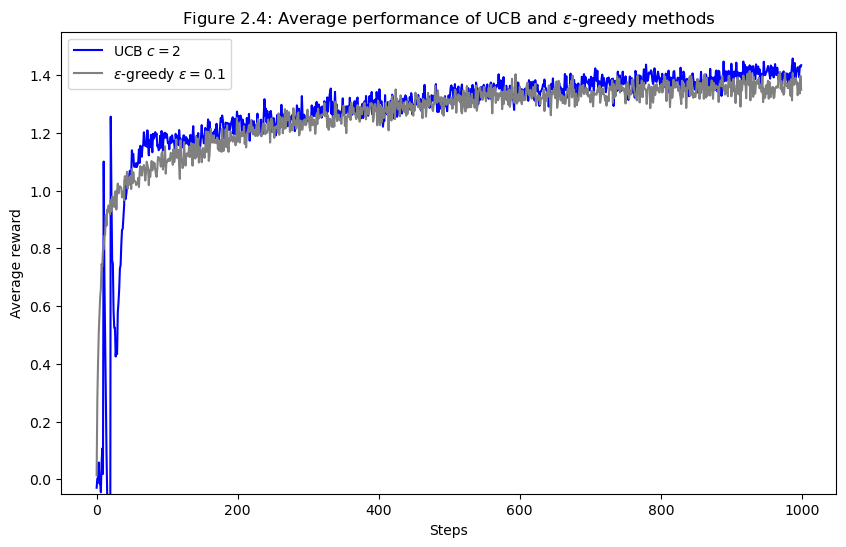

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def ucb_action_selection(bandit, c):
    ucb_values = bandit.q_estimates + c * np.sqrt(np.log(bandit.time + 1) / (bandit.action_counts + 1e-5))
    return np.argmax(ucb_values)

def run_experiment_ucb(c, steps=1000, runs=2000, alpha=0.1):
    rewards = np.zeros(steps)
    
    for _ in range(runs):
        bandit = Bandit()
        
        for step in range(steps):
            bandit.time = step
            action = ucb_action_selection(bandit, c)
            reward = bandit.step(action)
            bandit.update_estimates(action, reward, alpha)
            rewards[step] += reward
                
    rewards /= runs
    
    return rewards

def run_experiment_epsilon(epsilon, steps=1000, runs=2000, alpha=0.1):
    rewards = np.zeros(steps)
    
    for _ in range(runs):
        bandit = Bandit()
        
        for step in range(steps):
            action = bandit.select_action(epsilon)
            reward = bandit.step(action)
            bandit.update_estimates(action, reward, alpha)
            rewards[step] += reward
                
    rewards /= runs
    
    return rewards

# Parameters
steps = 1000
runs = 2000
alpha = 0.1

# Run experiments
rewards_ucb = run_experiment_ucb(c=2, steps=steps, runs=runs, alpha=alpha)
rewards_epsilon = run_experiment_epsilon(epsilon=0.1, steps=steps, runs=runs, alpha=alpha)

# Plotting
plt.figure(figsize=(10, 6))

# Plot average rewards
plt.plot(rewards_ucb, label='UCB $c=2$', color='blue')
plt.plot(rewards_epsilon, label='$\epsilon$-greedy $\epsilon=0.1$', color='gray')

plt.ylim(-0.05, 1.55)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.title('Figure 2.4: Average performance of UCB and $\epsilon$-greedy methods')
plt.show()

## Figure 2.5

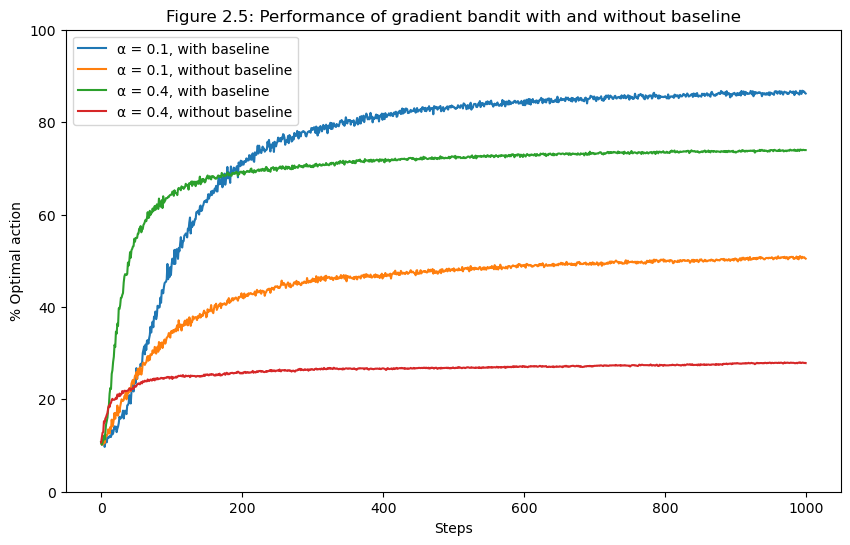

In [100]:
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

def run_experiment(alpha, use_baseline, steps=1000, runs=2000):
    optimal_action_counts = np.zeros(steps)
    
    for _ in range(runs):
        bandit = GradientBandit(alpha=alpha, mu=4, use_baseline=use_baseline)
        optimal_action = np.argmax(bandit.q_true)
        
        for step in range(steps):
            action = bandit.select_action()
            reward = np.random.normal(bandit.q_true[action], 1)
            bandit.update_preferences(action, reward)
            
            if action == optimal_action:
                optimal_action_counts[step] += 1
                
    optimal_action_counts /= runs
    
    return optimal_action_counts

# Parameters
steps = 1000
runs = 2000
alphas = [0.1, 0.4]

# Prepare arguments for parallel execution
args_with_baseline = [(alpha, True, steps, runs) for alpha in alphas]
args_without_baseline = [(alpha, False, steps, runs) for alpha in alphas]

# Run experiments
results_with_baseline = {}
results_without_baseline = {}

def run_experiment_wrapper(args):
    return run_experiment(*args)

with ProcessPoolExecutor() as executor:
    # Run with baseline
    futures_with_baseline = executor.map(run_experiment_wrapper, args_with_baseline)
    for alpha, result in zip(alphas, futures_with_baseline):
        results_with_baseline[alpha] = result
    
    # Run without baseline
    futures_without_baseline = executor.map(run_experiment_wrapper, args_without_baseline)
    for alpha, result in zip(alphas, futures_without_baseline):
        results_without_baseline[alpha] = result

# Plotting
plt.figure(figsize=(10, 6))

# Plot % optimal action
for alpha in alphas:
    plt.plot(results_with_baseline[alpha] * 100, label=f'α = {alpha}, with baseline')
    plt.plot(results_without_baseline[alpha] * 100, label=f'α = {alpha}, without baseline')

plt.ylim(0, 100)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.title('Figure 2.5: Performance of gradient bandit with and without baseline')
plt.show()

## Figure 2.6

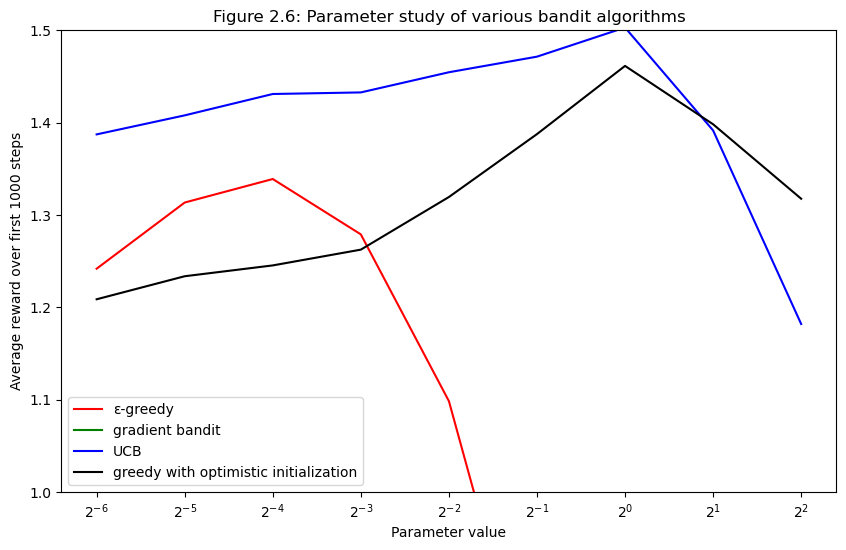

In [101]:
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

def ucb_action_selection(bandit, c):
    ucb_values = bandit.q_estimates + c * np.sqrt(np.log(bandit.time + 1) / (bandit.action_counts + 1e-5))
    return np.argmax(ucb_values)

def run_experiment(method, param, steps=1000, runs=2000):
    rewards = np.zeros(steps)
    
    for _ in range(runs):
        if method == 'epsilon_greedy':
            bandit = Bandit()
            for step in range(steps):
                action = bandit.select_action(param)
                reward = bandit.step(action)
                bandit.update_estimates(action, reward)
                rewards[step] += reward

        elif method == 'ucb':
            bandit = Bandit()
            for step in range(steps):
                bandit.time = step
                action = ucb_action_selection(bandit, param)
                reward = bandit.step(action)
                bandit.update_estimates(action, reward)
                rewards[step] += reward

        elif method == 'gradient_bandit':
            bandit = GradientBandit(alpha=param, use_baseline=True)
            for step in range(steps):
                action = bandit.select_action()
                reward = np.random.normal(bandit.q_true[action], 1)
                bandit.update_preferences(action, reward)
                rewards[step] += reward

        elif method == 'optimistic_greedy':
            bandit = Bandit(q1=param)
            for step in range(steps):
                action = bandit.select_action(0)
                reward = bandit.step(action)
                bandit.update_estimates(action, reward, alpha=0.1)
                rewards[step] += reward

    rewards /= runs
    return np.mean(rewards)

# Parameters
steps = 1000
runs = 2000
epsilon_values = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
alpha_values = epsilon_values
c_values = epsilon_values
q0_values = epsilon_values

# Define a wrapper function for run_experiment to handle tuple unpacking
def run_experiment_wrapper(args):
    return run_experiment(*args)

# Prepare parameters for parallel execution
experiment_params = []
experiment_params.extend([('epsilon_greedy', eps, steps, runs) for eps in epsilon_values])
experiment_params.extend([('gradient_bandit', alpha, steps, runs) for alpha in alpha_values])
experiment_params.extend([('ucb', c, steps, runs) for c in c_values])
experiment_params.extend([('optimistic_greedy', q0, steps, runs) for q0 in q0_values])

# Run experiments in parallel
results = []
with ProcessPoolExecutor() as executor:
    results = list(executor.map(run_experiment_wrapper, experiment_params))

# Split the results back into their respective lists
total_types = 4  # Number of experiment types
each_type_count = len(epsilon_values)  # Assuming all parameter lists are of the same length

epsilon_rewards = results[:each_type_count]
alpha_rewards = results[each_type_count:2*each_type_count]
c_rewards = results[2*each_type_count:3*each_type_count]
q0_rewards = results[3*each_type_count:4*each_type_count]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epsilon_values, epsilon_rewards, label='ε-greedy', color='red')
plt.plot(alpha_values, alpha_rewards, label='gradient bandit', color='green')
plt.plot(c_values, c_rewards, label='UCB', color='blue')
plt.plot(q0_values, q0_rewards, label='greedy with optimistic initialization', color='black')

plt.ylim(1, 1.5)
plt.xticks(epsilon_values, ['1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'])
plt.xscale('log', base=2)
plt.xlabel('Parameter value')
plt.ylabel('Average reward over first 1000 steps')
plt.legend()
plt.title('Figure 2.6: Parameter study of various bandit algorithms')
plt.show()